In [6]:
import sys, os, json, copy, sklearn, shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict as ddict

sys.path.insert(1, "../..")
from src.feature_selection import (
    get_top_k_features,
    get_monotone_dir,
    remove_corr_fts,
    get_feature_by_lgbm_importance,
    get_feature_shap_abs
)
from rdsutils.metrics import (
    get_binary_metrics,
    get_pred_reports
)
from src import aa_code

plt.style.use("seaborn")
%load_ext autoreload
%autoreload 2

In [7]:
local_artifact_path = "../../artifacts/final_model/"

In [8]:
segment = "prescreen_final"
seed = 42
artifact_path = "s3://sofi-data-science/jxu/pl-gen4/prescreen"
data_dir = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen"
nr_to_consider = 100

# training data
target = "target"
target_indeterminate = "indeterminate"
ri_weight = "weight_ri"
weight = "weight"
weight_eval = "weight_eval"

In [9]:
with open(os.path.join(artifact_path, "config.json"), "rb") as f:
    config = json.load(f)

with open(os.path.join(artifact_path, segment, "mp_woe_imputer_state_dict.pkl"), "rb") as f:
    imputer_state_dict = pkl.load(f)
    
with open(os.path.join(artifact_path, segment, "monotone_dict.json"), "r") as f:
    monotone_dict = json.load(f)
    
with open(os.path.join(artifact_path, segment, "woe_dict.pkl"), "rb") as f:
    woe_dict = pkl.load(f)
    
with open(config["models"]["prescreen"]["lgbm_31_hp"], "rb") as f:
    model = pkl.load(f)
    
    

In [10]:
# columns to load
meta_cols = [
    target, target_indeterminate,
    ri_weight, weight_eval, weight, 'applicant_fico_score',
    'applicant_type', 'applicant_vantage_score', 'date_start',
    'gen3_score', 'id','period','ri_source', 'segmentation',
    'segmentation_description',
]
features = model.feature_name_.copy()
cols = meta_cols + features

# load data
df_unimp = pd.read_parquet(config["data"]["prescreen-final"]["df"], columns=cols)
test_df_unimp = pd.read_parquet(config["data"]["prescreen-final"]["test_df"], columns=cols)
df = pd.read_parquet(config["data"]["prescreen-final"]["df_imputed"], columns=cols)
test_df = pd.read_parquet(config["data"]["prescreen-final"]["test_df_imputed"], columns=cols)

### Data Statitics
---

In [11]:
df_unimp[[weight, "ri_source"]].groupby("ri_source")[weight].sum().round(2)

ri_source
booked    273651.50
others    444556.88
proxy     397572.00
Name: weight, dtype: float64

In [12]:
# 25%
df_ = df_unimp[[weight, "ri_source"]].groupby("ri_source")[weight].sum()
df_ /= df_.sum()
df_.loc[["booked", "proxy", "others"]]

ri_source
booked    0.245256
proxy     0.356317
others    0.398427
Name: weight, dtype: float64

#### Model
---

In [13]:
final_features = model.feature_name_.copy()
final_features

['p13_upl8132',
 'p13_bcc8322',
 'p13_bcc5520',
 't11_tall3205',
 'p13_upl0438',
 'p13_all7312',
 'p13_all7518',
 'p13_rta7300',
 'p13_iqz9420',
 'p13_iqf9540',
 'p13_iqt9510',
 'p13_iqz9425',
 't11_trev0722',
 't11_tstu2752',
 't11_tiln2755',
 't11_tmti2752',
 't11_tiln2754',
 'p13_all7936',
 'p13_all8352',
 'p13_cru1300',
 'p13_reh7120',
 't11_tbca2526',
 't11_tbca3530',
 't11_tbca4504',
 't11_tbca2381',
 't11_tbcc3305',
 't11_tbcc1303',
 'p13_upl8320',
 'p13_aut8140',
 'p13_cru8320',
 'p13_rtr5520']

In [14]:
from pprint import pprint
pprint(final_features, compact=True)

['p13_upl8132', 'p13_bcc8322', 'p13_bcc5520', 't11_tall3205', 'p13_upl0438',
 'p13_all7312', 'p13_all7518', 'p13_rta7300', 'p13_iqz9420', 'p13_iqf9540',
 'p13_iqt9510', 'p13_iqz9425', 't11_trev0722', 't11_tstu2752', 't11_tiln2755',
 't11_tmti2752', 't11_tiln2754', 'p13_all7936', 'p13_all8352', 'p13_cru1300',
 'p13_reh7120', 't11_tbca2526', 't11_tbca3530', 't11_tbca4504', 't11_tbca2381',
 't11_tbcc3305', 't11_tbcc1303', 'p13_upl8320', 'p13_aut8140', 'p13_cru8320',
 'p13_rtr5520']


In [15]:
final_params = model.get_params()
final_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.007,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 2500,
 'n_jobs': -1,
 'num_leaves': 45,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc',
 'verbosity': -1,
 'early_stopping_rounds': None,
 'feature_pre_filter': False,
 'lambda_l1': 3.9,
 'lambda_l2': 8.4,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.9,
 'min_data_in_leaf': 700,
 'monotone_constraints': [-1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  -1],
 'seed': 42}

In [16]:
n_samples = 100000
sample_df = df.sample(n_samples, random_state=seed)

#### Refactoring the AACode Class
---

What attributes do AACode class have?

* abstract class - logic
* visualization - if provided
* inference

Essentially this class should only have a transform action, as fitting are very technique dependent. For example, monotonicity + WOE requires the specific model type, and all we need at inference time is the model object along with the data points.

* Args:
    * Train
        * model - booster, since this is the most atomic structure for LGBM. Actually maybe should require it having a predict module or define a specific wrapper class for the model.
        * data, woe dictionary (?), arguments
            * eventually the eventual valid values of the dataset
            * special focus on missing values and special encodings
    * Inference
        * model
        * data points
        
* returns:
    * data frame containing top negatively impact features

In [23]:
# AA DF

aa_path =  '../../artifacts/aa_code/final_model_features aa.xlsx - Prescreen Model.csv'
aa_source = pd.read_csv(aa_path)

In [24]:
aa_source

,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1
0,p13_bcc5520,Average credit amount on open revolving bankca...,1,P06,Average credit amount on bank revolving accoun...,V49,Lack of sufficient relevant bankcard or revolv...
1,t11_tmti2752,Total actual payment over the last 6 months on...,2,P01,Actual payment on mortgage loans is too low,V23,Lack of sufficient relevant account information
2,t11_tstu2752,Total actual payment over the last 6 months on...,3,P02,Actual payment on student loan accounts is too...,V23,Lack of sufficient relevant account information
3,p13_iqz9420,Total number of inquiries (deduplication appli...,4,V85,You have too many inquiries on your credit report,-,-
4,t11_tall3205,Number of months with aggregate balance decrea...,5,P22,Total balances on your accounts are too high o...,V23,Lack of sufficient relevant account information
5,p13_bcc8322,Average number of months since open revolving ...,6,V31,Bankcard or other revolving accounts were open...,V49,Lack of sufficient relevant bankcard or revolv...
6,t11_tbca4504,Months since most recent balance over credit a...,7,P18,Time since balance over credit amount on bankc...,V23,Lack of sufficient relevant account information
7,p13_upl8132,Number of days since the most recently opened ...,8,P17,The date you opened your newest unsecured pers...,V23,Lack of sufficient relevant account information
8,t11_trev0722,Difference between Q1 (m00-m03) total average ...,9,P16,Scheduled Payment on revolving trades has an i...,V23,Lack of sufficient relevant account information
9,p13_all7936,Percentage of trades reported in the last 6 mo...,10,P15,Percentage of trades with delinquent or deroga...,V23,Lack of sufficient relevant account information


In [25]:
aa_source["attr"] = aa_source["field_name"]

In [26]:
# FAKE AA DF

dd_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv'
exp_ddict_updated = pd.read_csv(dd_path, index_col=0)

# aa_source = exp_ddict_updated[exp_ddict_updated.field_name.isin(model.feature_name_)].copy()
# aa_source["AA_code_valid"] = aa_source["field_name"] + "_aatmp"
# aa_source["AA_code_missing"] = aa_source["field_name"] + "_missing"
# aa_source["attr"] = aa_source["field_name"]

# impact_df,aa_top = adverse_action_code(input_row, pdp_obj, model.booster_, aa_source)

In [15]:
# %%timeit
# impact_df, aa_top = build_aa_code_pdp(input_row, pdp_dict, aa_source)

### PDP End to End
---

In [ ]:
%%time
AACode = aa_code.AACodePDP(model, aa_source, features)
AACode.fit(sample_df)

 45%|████▌     | 14/31 [03:55<04:45, 16.79s/it]

In [ ]:
fig, axs = AACode.plot()

In [ ]:
i=0
input_row = df.iloc[i].to_frame().T
display(input_row)

In [ ]:
AACode.transform(input_row)

### PDP SHAP
---

In [21]:
%%time
X_small = sample_df[features].head(1000)
y_small = sample_df[target].head(1000)
explainer = shap.TreeExplainer(model, data=X_small, model_output="probability")
shap_values = explainer.shap_values(X_small.values,
                                    y=y_small,
                                    check_additivity=True,
                                   )

 99%|===================| 994/1000 [01:26<00:00]        

CPU times: user 1min 28s, sys: 225 ms, total: 1min 28s
Wall time: 1min 27s


In [22]:
%%time
explainer_lgb = shap.Explainer(model.booster_.predict, X_small)  # what is the second parameter?
shap_values_lgb = explainer_lgb(X_small)

Permutation explainer: 1001it [02:53,  5.43it/s]                          

CPU times: user 4h 36min 13s, sys: 666 ms, total: 4h 36min 14s
Wall time: 2min 53s


ValueError: too many values to unpack (expected 1)

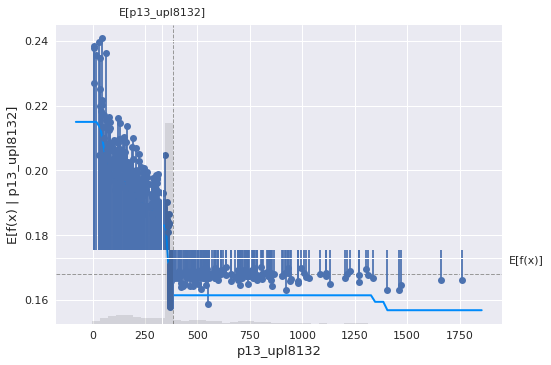

In [23]:
%%time
ft = features[0]
shap_explainer_lgb = shap.plots.partial_dependence(ft, model.booster_.predict, 
                                   X_small, model_expected_value=True, ice=False,
                                   feature_expected_value=True, shap_values=shap_values_lgb[:len(X_small)])

TypeError: memoryview: invalid slice key

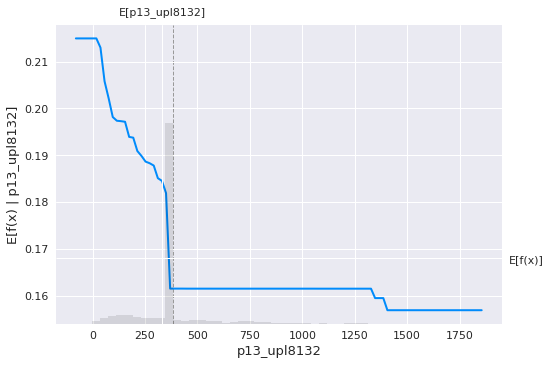

In [24]:
%%time
ft = features[0]
shap_explainer_lgb = shap.plots.partial_dependence(ft, model.booster_.predict, 
                                   X_small, ice=False, model_expected_value=True, 
                                   feature_expected_value=True, shap_values=shap_values[:len(X_small)],
                                   show=False)

CPU times: user 3min 47s, sys: 11.6 ms, total: 3min 47s
Wall time: 2.39 s


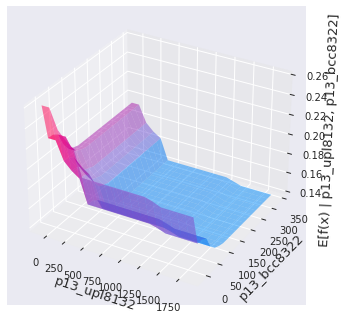

In [27]:
%%time
fts = (features[0], features[1])
shap_explainer_lgb = shap.plots.partial_dependence(fts, model.booster_.predict, 
                                   X_small, ice=False, model_expected_value=True, 
                                   feature_expected_value=True, shap_values=shap_values_lgb[:len(X_small)],
                                   show=False)

In [35]:
X_ = sample_df[features+[target]].head(1000)

ValueError: too many values to unpack (expected 1)

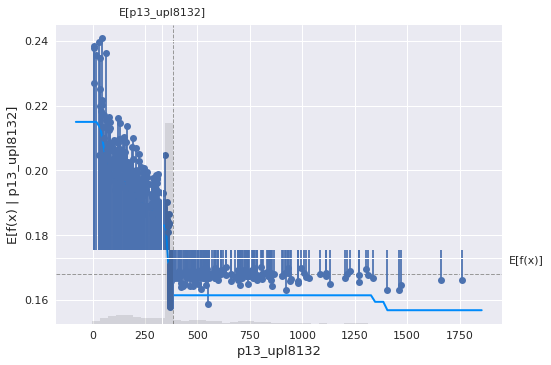

In [41]:
%%time
ft = features[0]
shap_explainer_lgb = shap.plots.partial_dependence(ft, model.booster_.predict, 
                                   X_small, ice=False, model_expected_value=True, 
                                   feature_expected_value=True, shap_values=shap_values_lgb[:len(X_small)],
                                   show=False)

In [ ]:
# SHAP implementation

def partial_dependence(ind, model, data, xmin="percentile(0)", xmax="percentile(100)",
                       npoints=None, feature_names=None, hist=True, model_expected_value=False,
                       feature_expected_value=False, shap_values=None,
                       ylabel=None, ice=True, ace_opacity=1, pd_opacity=1, pd_linewidth=2,
                       ace_linewidth='auto', ax=None, show=True):
    """ A basic partial dependence plot function.
    """

    if isinstance(data, Explanation):
        features = data.data
        shap_values = data
    else:
        features = data

    # convert from DataFrames if we got any
    use_dataframe = False
    if str(type(features)).endswith("'pandas.core.frame.DataFrame'>"):
        if feature_names is None:
            feature_names = features.columns
        features = features.values
        use_dataframe = True

    if feature_names is None:
        feature_names = ["Feature %d" % i for i in range(features.shape[1])]

    # this is for a 1D partial dependence plot
    if type(ind) is not tuple:
        ind = convert_name(ind, None, feature_names)
        xv = features[:,ind]
        xmin, xmax = compute_bounds(xmin, xmax, xv)
        npoints = 100 if npoints is None else npoints
        xs = np.linspace(xmin, xmax, npoints)


        if ice:
            features_tmp = features.copy()
            ice_vals = np.zeros((npoints, features.shape[0]))
            for i in range(npoints):
                features_tmp[:,ind] = xs[i]
                if use_dataframe:
                    ice_vals[i,:] = model(pd.DataFrame(features_tmp, columns=feature_names))
                else:
                    ice_vals[i,:] = model(features_tmp)
            # if linewidth is None:
            #     linewidth = 1
            # if opacity is None:
            #     opacity = 0.5

        features_tmp = features.copy()
        vals = np.zeros(npoints)
        for i in range(npoints):
            features_tmp[:,ind] = xs[i]
            if use_dataframe:
                vals[i] = model(pd.DataFrame(features_tmp, columns=feature_names)).mean()
            else:
                vals[i] = model(features_tmp).mean()




        if ax is None:
            fig = pl.figure()
            ax1 = pl.gca()
        else:
            fig = pl.gcf()
            ax1 = pl.gca()

        #fig, ax1 = pl.subplots(figsize)
        ax2 = ax1.twinx()

        # the histogram of the data
        if hist:
            #n, bins, patches = 
            ax2.hist(xv, 50, density=False, facecolor='black', alpha=0.1, range=(xmin, xmax))



        # ice line plot
        if ice:
            if ace_linewidth == "auto":
                ace_linewidth = min(1, 50/ice_vals.shape[1]) # pylint: disable=unsubscriptable-object
            ax1.plot(xs, ice_vals, color=light_blue_rgb, linewidth=ace_linewidth, alpha=ace_opacity)

        # the line plot
        ax1.plot(xs, vals, color=blue_rgb, linewidth=pd_linewidth, alpha=pd_opacity)

        ax2.set_ylim(0,features.shape[0])#ax2.get_ylim()[0], ax2.get_ylim()[1] * 4)
        ax1.set_xlabel(feature_names[ind], fontsize=13)
        if ylabel is None:
            if not ice:
                ylabel = "E[f(x) | "+ str(feature_names[ind]) + "]"
            else:
                ylabel = "f(x) | "+ str(feature_names[ind])
        ax1.set_ylabel(ylabel, fontsize=13)
        ax1.xaxis.set_ticks_position('bottom')
        ax1.yaxis.set_ticks_position('left')
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.tick_params(labelsize=11)

        ax2.xaxis.set_ticks_position('bottom')
        ax2.yaxis.set_ticks_position('left')
        ax2.yaxis.set_ticks([])
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)


        if feature_expected_value is not False:
            ax3=ax2.twiny()
            ax3.set_xlim(xmin,xmax)
            mval = xv.mean()
            ax3.set_xticks([mval])
            ax3.set_xticklabels(["E["+str(feature_names[ind])+"]"])
            ax3.spines['right'].set_visible(False)
            ax3.spines['top'].set_visible(False)
            ax3.tick_params(length=0, labelsize=11)
            ax1.axvline(mval, color="#999999", zorder=-1, linestyle="--", linewidth=1)

        if model_expected_value is not False or shap_values is not None:
            if model_expected_value is True:
                if use_dataframe:
                    model_expected_value = model(pd.DataFrame(features, columns=feature_names)).mean()
                else:
                    model_expected_value = model(features).mean()
            else:
                model_expected_value = shap_values.base_values
            ymin,ymax = ax1.get_ylim()
            ax4=ax2.twinx()
            ax4.set_ylim(ymin,ymax)
            ax4.set_yticks([model_expected_value])
            ax4.set_yticklabels(["E[f(x)]"])
            ax4.spines['right'].set_visible(False)
            ax4.spines['top'].set_visible(False)
            ax4.tick_params(length=0, labelsize=11)
            ax1.axhline(model_expected_value, color="#999999", zorder=-1, linestyle="--", linewidth=1)

        if shap_values is not None:
            # vals = shap_values.values[:, ind]
            # if shap_value_features is None:
            #     shap_value_features = features
            #     assert shap_values.shape == features.shape
            # #sample_ind = 18
            # vals = shap_values[:, ind]
            # if type(model_expected_value) is bool:
            #     if use_dataframe:
            #         model_expected_value = model(pd.DataFrame(features, columns=feature_names)).mean()
            #     else:
            #         model_expected_value = model(features).mean()
            # if str(type(shap_value_features)).endswith("'pandas.core.frame.DataFrame'>"):
            #     shap_value_features = shap_value_features.values
            markerline, stemlines, _ = ax1.stem(
                shap_values.data[:,ind], shap_values.base_values + shap_values.values[:, ind],
                bottom=shap_values.base_values, 
                markerfmt="o", basefmt=" ", use_line_collection=True
            )
            stemlines.set_edgecolors([red_rgb if v > 0 else blue_rgb for v in vals])
            pl.setp(stemlines, 'zorder', -1)
            pl.setp(stemlines, 'linewidth', 2)
            pl.setp(markerline, 'color', "black")
            pl.setp(markerline, 'markersize', 4)

        if show:
            pl.show()
        else:
            return fig,ax1


    # this is for a 2D partial dependence plot
    else:
        ind0 = convert_name(ind[0], None, feature_names)
        ind1 = convert_name(ind[1], None, feature_names)
        xv0 = features[:,ind0]
        xv1 = features[:,ind1]

        xmin0 = xmin[0] if type(xmin) is tuple else xmin
        xmin1 = xmin[1] if type(xmin) is tuple else xmin
        xmax0 = xmax[0] if type(xmax) is tuple else xmax
        xmax1 = xmax[1] if type(xmax) is tuple else xmax

        xmin0, xmax0 = compute_bounds(xmin0, xmax0, xv0)
        xmin1, xmax1 = compute_bounds(xmin1, xmax1, xv1)
        npoints = 20 if npoints is None else npoints
        xs0 = np.linspace(xmin0, xmax0, npoints)
        xs1 = np.linspace(xmin1, xmax1, npoints)

        features_tmp = features.copy()
        x0 = np.zeros((npoints, npoints))
        x1 = np.zeros((npoints, npoints))
        vals = np.zeros((npoints, npoints))
        for i in range(npoints):
            for j in range(npoints):
                features_tmp[:,ind0] = xs0[i]
                features_tmp[:,ind1] = xs1[j]
                x0[i, j] = xs0[i]
                x1[i, j] = xs1[j]
                vals[i, j] = model(features_tmp).mean()

        fig = pl.figure()
        ax = fig.add_subplot(111, projection='3d')


#         x = y = np.arange(-3.0, 3.0, 0.05)
#         X, Y = np.meshgrid(x, y)
#         zs = np.array(fun(np.ravel(X), np.ravel(Y)))
#         Z = zs.reshape(X.shape)

        ax.plot_surface(x0, x1, vals, cmap=red_blue_transparent)

        ax.set_xlabel(feature_names[ind0], fontsize=13)
        ax.set_ylabel(feature_names[ind1], fontsize=13)
        ax.set_zlabel("E[f(x) | "+ str(feature_names[ind0]) + ", "+ str(feature_names[ind1]) + "]", fontsize=13)

        if show:
            pl.show()
        else:
            return fig, ax